In [1]:
train_path = "/kaggle/input/fruits-vegetables/fruit-and-veggies/training"
test_path = "/kaggle/input/fruits-vegetables/fruit-and-veggies/test"
val_path = "/kaggle/input/fruits-vegetables/fruit-and-veggies/validation"

In [2]:
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall
from tensorflow.keras.utils import img_to_array, load_img

import warnings
warnings.filterwarnings("ignore")

In [3]:
BATCH_SIZE = 10
TARGET_SIZE = (100,100)
SEED = 10

In [4]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                          rotation_range = 45,
                                          horizontal_flip = True,
                                          vertical_flip = True,
                                         preprocessing_function = preprocess_input)

train_set = train_data_generator.flow_from_directory(train_path,
                                                     target_size = TARGET_SIZE,
                                                     batch_size = BATCH_SIZE,
                                                     color_mode="rgb",
                                                     class_mode = "categorical",
                                                     shuffle = True,
                                                     seed = SEED)

Found 1456 images belonging to 28 classes.


In [5]:
test_data_generator = ImageDataGenerator(rescale = 1./255,
                                        preprocessing_function = preprocess_input)

test_set = test_data_generator.flow_from_directory(test_path,
                                                   target_size = TARGET_SIZE,
                                                   batch_size = 1,
                                                   color_mode="rgb",
                                                   shuffle = False,
                                                   class_mode = None)

Found 200 images belonging to 1 classes.


In [6]:
val_data_generator = ImageDataGenerator(rescale = 1./255,
                                       preprocessing_function = preprocess_input)

val_set = val_data_generator.flow_from_directory(val_path,
                                                 target_size = TARGET_SIZE,
                                                 batch_size = BATCH_SIZE,
                                                 color_mode="rgb",
                                                 class_mode = "categorical",
                                                 shuffle = True,
                                                 seed = SEED)

Found 420 images belonging to 28 classes.


In [7]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(100,100,3))
base_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [8]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [11]:
# # Defining the CNN layers

# # Layer 1
# model = Sequential()
# model.add(Conv2D(filters=32, input_shape=(100,100,3), activation="relu", kernel_size=(3,3)))
# model.add(MaxPooling2D(pool_size=(2,2)))

# # Layer 2
# model.add(Conv2D(filters=64, activation="relu", kernel_size=(3,3)))
# model.add(MaxPooling2D(pool_size=(2,2)))

# # Layer 3
# model.add(Conv2D(filters=128, activation="relu", kernel_size=(3,3)))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.5))

# # Flattening the model
# model.add(Flatten())

# # The fully-connected layer
# model.add(Dense(units=256, activation="relu"))
# model.add(Dense(units=128, activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# # Output layer
# model.add(Dense(units=28, activation="softmax"))

# # Compiling the model
# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", Precision(), Recall()])
# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

In [10]:
flatten = Flatten()
dense_1 = Dense(units=256, activation="relu")
dense_2 = Dense(units=128, activation="relu")

# prediction layer
pred_layer = Dense(units=28, activation="softmax")

model = Sequential([
    base_model,
    flatten,
    dense_1,
    dense_2,
    pred_layer
])

In [11]:
model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy", Precision(), Recall()]
)

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [13]:
es = EarlyStopping(monitor="val_loss", patience=30, verbose=1, restore_best_weights=True, mode="min")
mc = ModelCheckpoint("/kaggle/working/checkpoint/checkpoint.h5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)
lr = ReduceLROnPlateau(monitor="val_accuracy", verbose=1, mode="max", factor=0.01, min_delta=0.01, min_lr=0)

In [14]:
execute = model.fit(train_set,
                 epochs = 50,
                 batch_size = BATCH_SIZE,
                 validation_data = val_set,
                 callbacks = [es,mc,lr])

Epoch 1/50
146/146 [==============================] - ETA: 0s - loss: 1.4538 - accuracy: 0.5913 - precision: 0.8588 - recall: 0.4011
Epoch 1: val_accuracy improved from -inf to 0.85476, saving model to /kaggle/working/checkpoint/checkpoint.h5
146/146 [==============================] - 52s 290ms/step - loss: 1.4538 - accuracy: 0.5913 - precision: 0.8588 - recall: 0.4011 - val_loss: 0.5128 - val_accuracy: 0.8548 - val_precision: 0.9180 - val_recall: 0.8000 - lr: 0.0010
Epoch 2/50
146/146 [==============================] - ETA: 0s - loss: 0.4179 - accuracy: 0.8668 - precision: 0.9195 - recall: 0.8310
Epoch 2: val_accuracy improved from 0.85476 to 0.88810, saving model to /kaggle/working/checkpoint/checkpoint.h5
146/146 [==============================] - 34s 232ms/step - loss: 0.4179 - accuracy: 0.8668 - precision: 0.9195 - recall: 0.8310 - val_loss: 0.3384 - val_accuracy: 0.8881 - val_precision: 0.9269 - val_recall: 0.8452 - lr: 0.0010
Epoch 3/50
146/146 [==============================] -

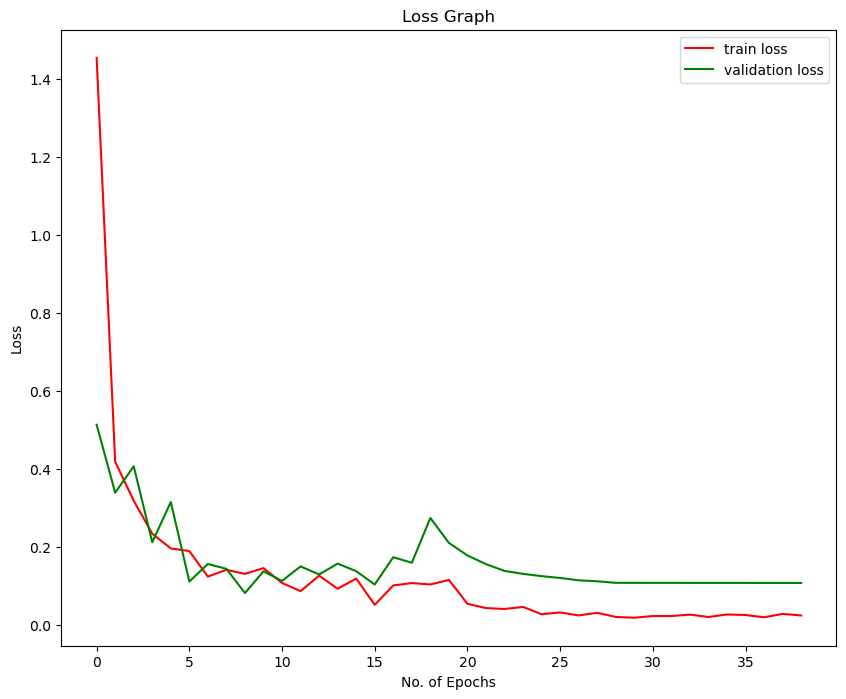

In [15]:
plt.figure(figsize=(10,8))
plt.plot(execute.history['loss'], "red", label="train loss")
plt.plot(execute.history['val_loss'], "green", label="validation loss")

plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Loss Graph")
plt.legend()
plt.savefig("/kaggle/working/loss_graph")
plt.show()

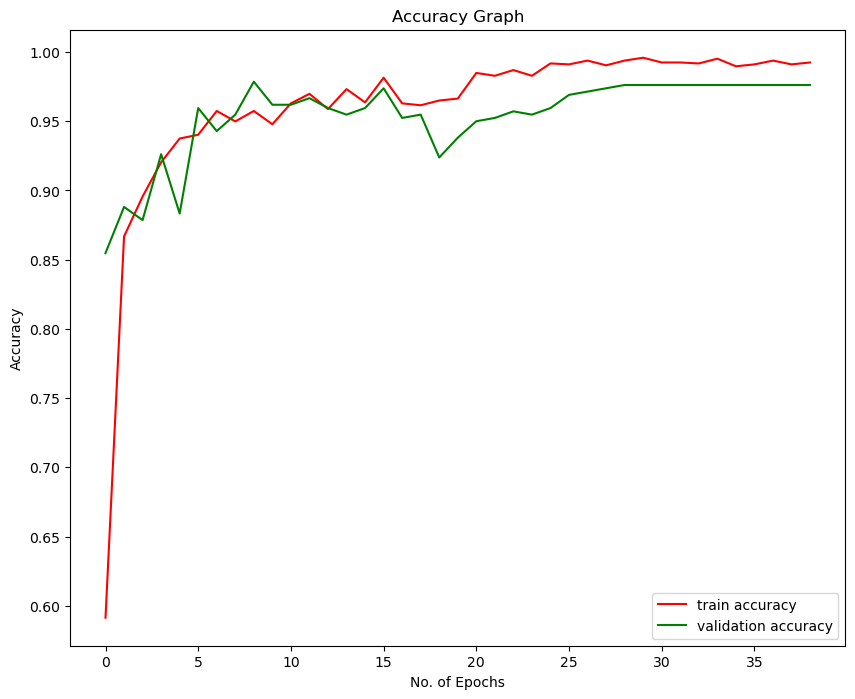

In [16]:
plt.figure(figsize=(10,8))
plt.plot(execute.history['accuracy'], "red", label="train accuracy")
plt.plot(execute.history['val_accuracy'], "green", label="validation accuracy")

plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Graph")
plt.legend()
plt.savefig("/kaggle/working/accuracy_graph")
plt.show()

In [17]:
model.evaluate(val_set, batch_size = 1)

42/42 [==============================] - 5s 118ms/step - loss: 0.0812 - accuracy: 0.9786 - precision: 0.9784 - recall: 0.9714


[0.08117088675498962,
 0.9785714149475098,
 0.9784172773361206,
 0.9714285731315613]

In [18]:
model.save("/kaggle/working/orange_detector.h5")
# model.save("/kaggle/working/orange_detector.tf")

In [ ]:
# model = load_model("/kaggle/working/orange_detector.h5")
# model

In [19]:
import os
import numpy as np
import random

In [20]:
classes = os.listdir("/kaggle/input/fruits-vegetables/fruit-and-veggies/training")
classes=sorted(classes)
print(classes)

results = np.zeros((28,))
print(results)

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'carrot', 'cauliflower', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'mango', 'onion', 'orange', 'orange b1', 'orange c2', 'orange g3', 'pear', 'pineapple', 'pomegranate', 'potato', 'raddish', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [21]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
test_set.reset()
predictions = probability_model.predict(test_set, verbose=1)
print(predictions)

200/200 [==============================] - 3s 13ms/step
[[0.03364993 0.03364993 0.03364993 ... 0.03364993 0.03364993 0.03364995]
 [0.03365217 0.03365217 0.03365217 ... 0.03365217 0.03365217 0.03365225]
 [0.03364933 0.03364933 0.03364933 ... 0.03364933 0.03364933 0.03364933]
 ...
 [0.03878262 0.0340788  0.03423043 ... 0.03407979 0.03677375 0.03407978]
 [0.03367401 0.03367345 0.03367857 ... 0.03367371 0.03367339 0.03367331]
 [0.03364932 0.03364932 0.03364932 ... 0.03364932 0.03364932 0.03364932]]


In [22]:
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

[ 4  4  3 21 16 14 10 18 12  8 14 19 15 17 14 17 14 16 24  2 19 13 13  2
 22  0 27 18 11  8 24 14 19 27  1 12  2 21 14 13 10  2  8 25 15 21 12 20
 17  3 17 11  3 24 15 17  2 24 23  3 26 21  8 15  7 16 18 17 16 13 19 11
 27 10 21 20  8 18  0 12 25 10 25  8  7  0  6 17 27 14 20 14 18 18 25 19
  1  0 15  7 25 18 11  3  0  5 17  7 23 24  1 26 14  7 11 18  6 14 14 22
  0 16 27 18 25  2 14 15  5  8 10 16 13  7 10  2  0 22  7 11 21 13 18  0
 14  1  1 23  4 23 12 18 18  0  3  0 25  1 15 11 16 23 19 14 22 16 14 16
 24 26 22  4 15 27 17 16  2  1 20 21 14 10  1  3  1 17 10 19 14 16 16 13
 13  2 21 24 13 13  8 19]


In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [24]:
# loading the model we saved
model = load_model('/kaggle/input/orange-model/orange_detector.h5')
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
# predicting images
predict_path = "/kaggle/input/fruits-vegetables/fruit-and-veggies/predict"

['15.jpg', '16.jpg', '8.jpeg', '22.jpg', '27.jpeg', '24.jpg', '14.jpeg', '5.jpeg', '9.jpg', '2.jpeg', '23.jpeg', '25.jpg', '28.jpg', '21.jpeg', '7.jpeg', '26.jpg', '20.jpg', '19.jpeg', '12.jpeg', '10.jpeg', '4.jpg', '11.jpeg', '6.jpeg', '17.jpg', '3.jpg', '1.jpeg', '13.jpeg', '18.jpg']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


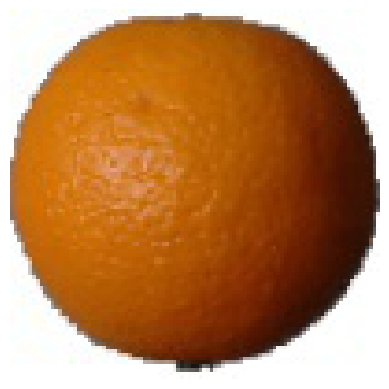

1/1 [==============================] - 0s 176ms/step
15.0


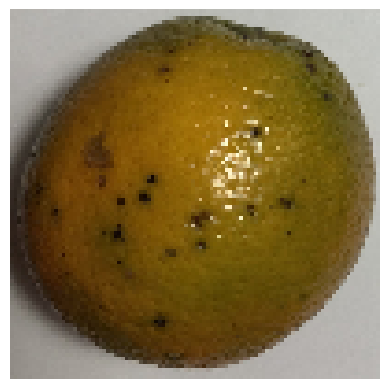

1/1 [==============================] - 0s 33ms/step
16.0


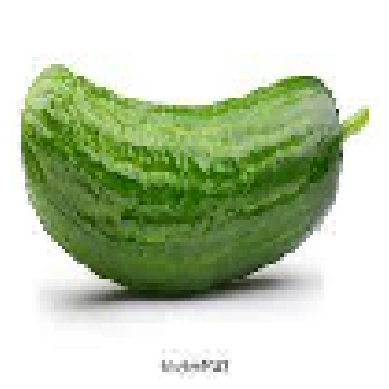

1/1 [==============================] - 0s 40ms/step
8.0


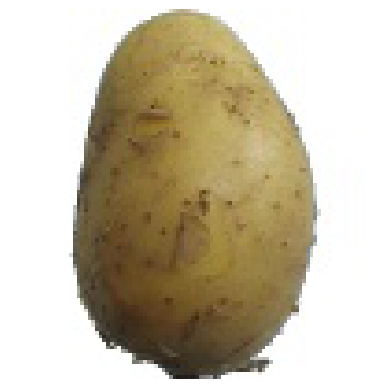

1/1 [==============================] - 0s 39ms/step
22.0


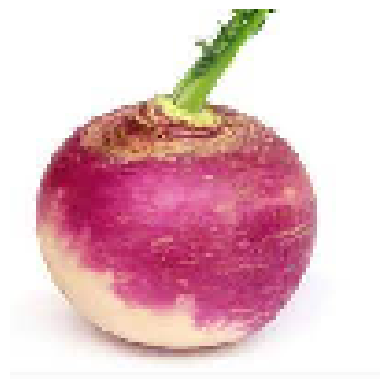

1/1 [==============================] - 0s 30ms/step
27.0


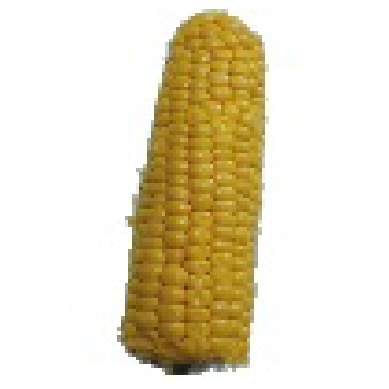

1/1 [==============================] - 0s 40ms/step
24.0


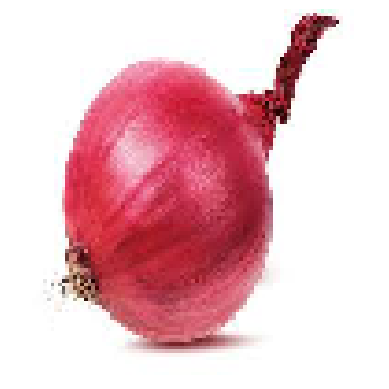

1/1 [==============================] - 0s 36ms/step
1.0


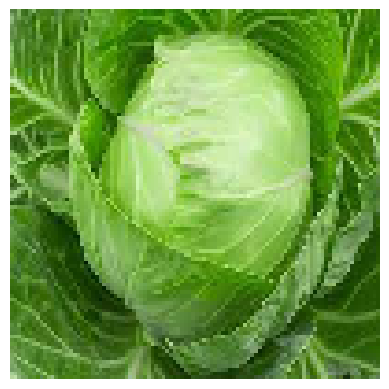

1/1 [==============================] - 0s 31ms/step
5.0


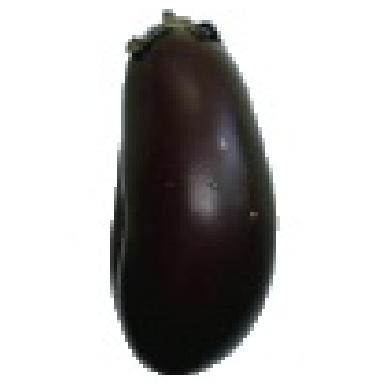

1/1 [==============================] - 0s 33ms/step
9.0


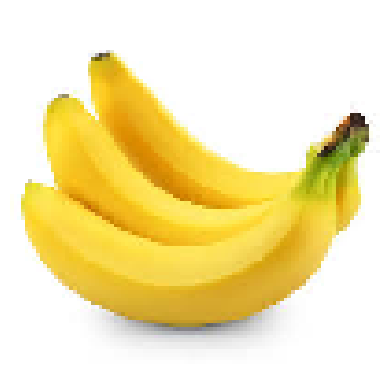

1/1 [==============================] - 0s 38ms/step
2.0


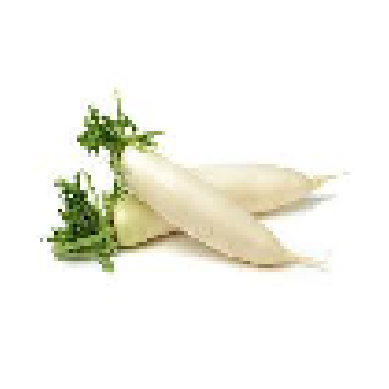

1/1 [==============================] - 0s 39ms/step
23.0


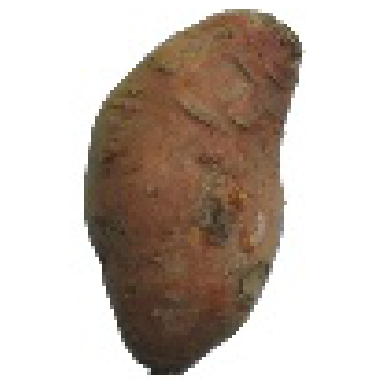

1/1 [==============================] - 0s 38ms/step
25.0


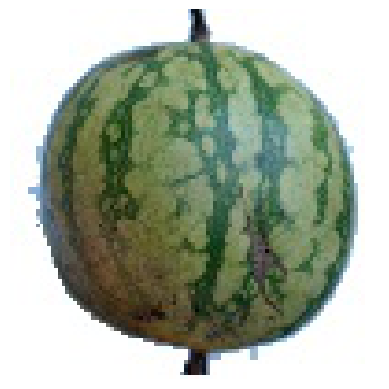

1/1 [==============================] - 0s 40ms/step
28.0


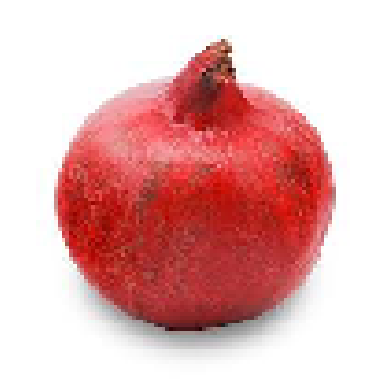

1/1 [==============================] - 0s 36ms/step
1.0


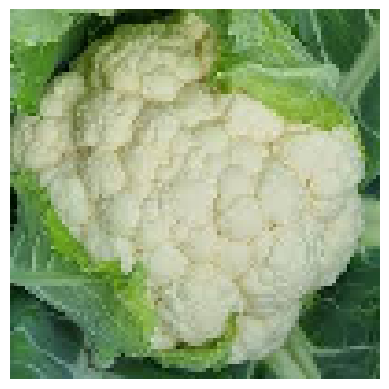

1/1 [==============================] - 0s 39ms/step
7.0


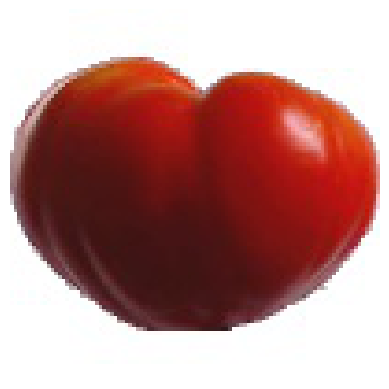

1/1 [==============================] - 0s 37ms/step
26.0


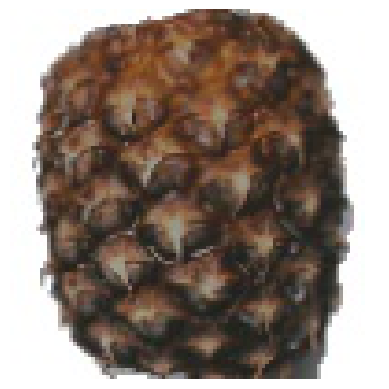

1/1 [==============================] - 0s 38ms/step
20.0


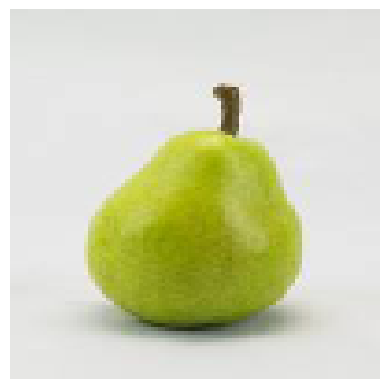

1/1 [==============================] - 0s 35ms/step
19.0


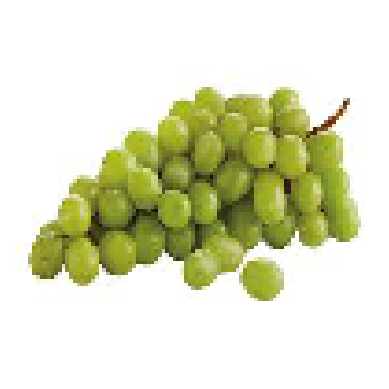

1/1 [==============================] - 0s 38ms/step
12.0


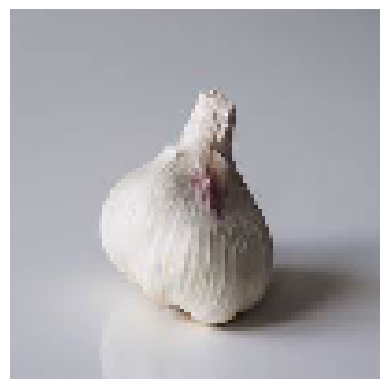

1/1 [==============================] - 0s 39ms/step
10.0


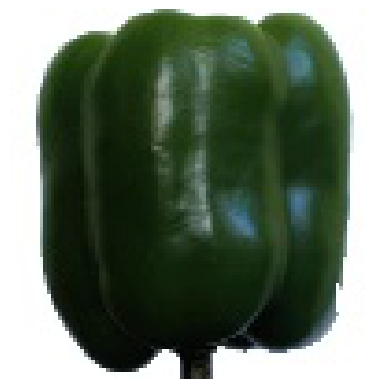

1/1 [==============================] - 0s 36ms/step
4.0


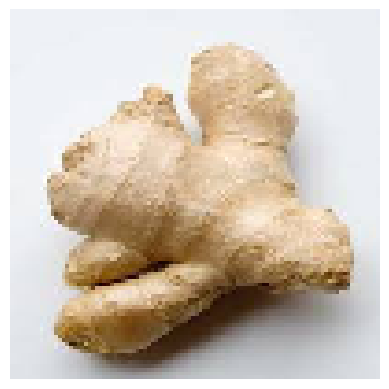

1/1 [==============================] - 0s 32ms/step
10.0


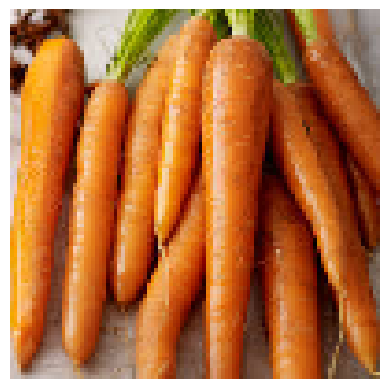

1/1 [==============================] - 0s 33ms/step
6.0


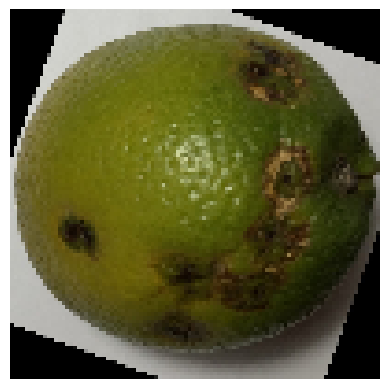

1/1 [==============================] - 0s 38ms/step
17.0


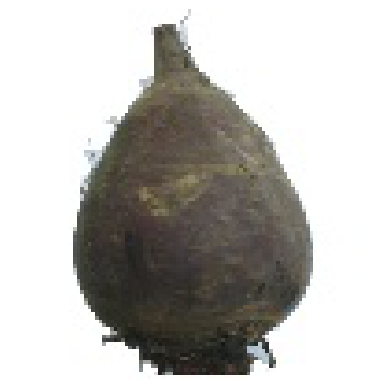

1/1 [==============================] - 0s 38ms/step
3.0


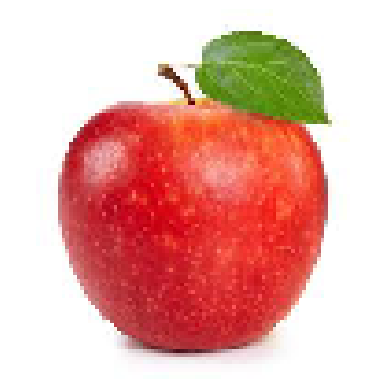

1/1 [==============================] - 0s 39ms/step
1.0


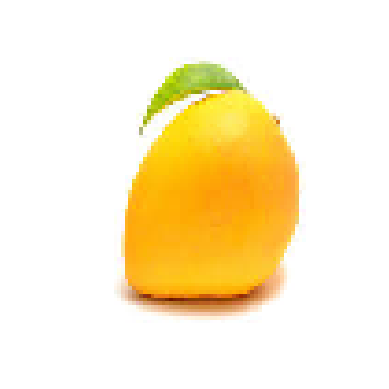

1/1 [==============================] - 0s 42ms/step
13.0


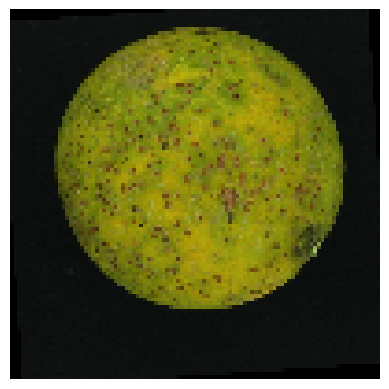

1/1 [==============================] - 0s 35ms/step
18.0
[15 16  8 22 27 24 14  5  9  2 23 25 28 21  7 26 20 19 12 10  4 11  6 17
  3  1 13 18]


In [26]:
files = os.listdir(predict_path)
random.shuffle(files)
print(files)

file_indexes = np.zeros((28,)).astype(int)
print(file_indexes)

for i, key in enumerate(classes):
    img_path = predict_path + "/" + files[i]
    file_indexes[i] = int(files[i].split(".")[0])
    
    img = load_img(img_path, target_size=(100,100))
    arr_img = img_to_array(img) / 255.
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    arr_img = np.expand_dims(arr_img, axis=0)
    results[i] = np.argmax(model.predict(arr_img)) + 1
    print(results[i])
    
print(file_indexes)

In [27]:
import seaborn as sb

In [28]:
cf_report = classification_report(file_indexes, results)
print(cf_report)

              precision    recall  f1-score   support

           1       0.33      1.00      0.50         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       0.50      1.00      0.67         1
          11       0.00      0.00      0.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       0.00      0.00      0.00         1
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1
          17       1.00      1.00      1.00         1
          18       1.00    

In [29]:
print(accuracy_score(file_indexes, results))

0.8928571428571429


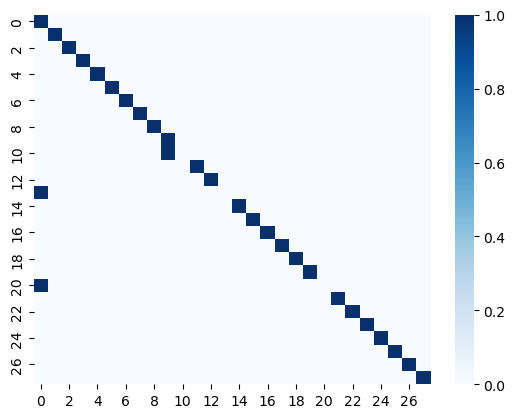

In [30]:
cf_matrix = confusion_matrix(file_indexes, results)
# print(cf_matrix)
sb_plot = sb.heatmap(cf_matrix, cmap='Blues')
sb_plot.figure.savefig("/kaggle/working/cf_matrix.png")

Enter image path:  /kaggle/input/fruits-vegetables/fruit-and-veggies/training/orange c2/canker (116).jpg


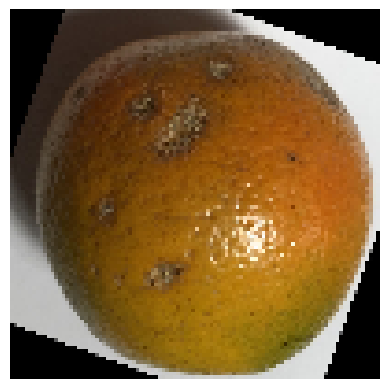

1/1 [==============================] - 0s 36ms/step
15
15
1


In [33]:
# function to test the model

def model_predict(path):
    # target size of our images
    img_width, img_height = 100, 100

    img = load_img(path, target_size=(img_width, img_height))
    arr_img = img_to_array(img)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    arr_img = np.expand_dims(arr_img, axis=0)
    value = np.argmax(model.predict(arr_img)) + 1
    print(value)

    if (value < 15 or value > 18):
        return 0
    else:
        print(value)
        return 1


path = input("Enter image path: ")
val = model_predict(path)
print(val)